In [14]:
%reload_ext autoreload
%autoreload 2

In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

from EVO import LogisticRegression, EvolutionOptimizer, DeepNeuralNetwork



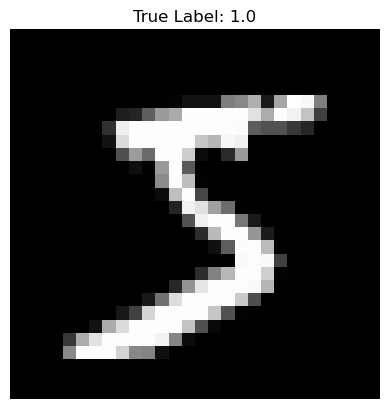

X_train_exp shape: torch.Size([60000, 7850])


In [16]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform that converts images to a tensor and flattens them.
transform = transforms.Compose([
    transforms.ToTensor(),                    # MNIST images are [1, 28, 28]
    transforms.Lambda(lambda x: x.view(-1))     # Flatten to [784]
])

# Load the MNIST training and test sets.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def add_bias(X):
    # X is of shape (N, 784), append a column of ones to yield shape (N, 785)
    N = X.size(0)
    bias = torch.ones(N, 1)
    return torch.cat([X, bias], dim=1)

# Build full training tensors.
X_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
X_train = add_bias(X_train)  # Now shape: (N_train, 785)
y_train = torch.tensor([float(train_dataset[i][1] > 4) for i in range(len(train_dataset))])

# Build full test tensors.
X_test = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
X_test = add_bias(X_test)   # Now shape: (N_test, 785)
y_test = torch.tensor([float(test_dataset[i][1] > 4) for i in range(len(test_dataset))])

def expand_features(X, num_classes=10):
    """
    Expand features from shape (N, d) to (N, d * num_classes) by forming blocks.
    Here we multiply each block by a unique constant so that each block is distinct.
    """
    N, d = X.shape
    blocks = []
    for c in range(num_classes):
        # Multiply the original features by (c+1)
        blocks.append( (c+1) * X )
    return torch.cat(blocks, dim=1)

# Expand the feature matrices so that each sample now has 7850 features.
X_train_exp = expand_features(X_train, num_classes=10)  # shape: (N_train, 7850)
X_test_exp  = expand_features(X_test, num_classes=10)   # shape: (N_test, 7850)

# (Optional) Visualize one original image.
img = X_train[0][:-1].view(28, 28)  # exclude bias from visualization
plt.imshow(img, cmap='gray')
plt.title(f"True Label: {y_train[0].item()}")
plt.axis('off')
plt.show()

print("X_train_exp shape:", X_train_exp.shape)  # Should be (N_train, 7850)

In [19]:
import torch

# Choose device: use MPS if available (Apple Silicon), else CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model on the chosen device.
model = LogisticRegression()

# Import your EvolutionOptimizer from EVO.py (unchanged).
from EVO import EvolutionOptimizer

# Instantiate the evolutionary optimizer.
optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(30)
optimizer.set_mutation_rate(0.3)
optimizer.set_mutation_intensity(0.6)
optimizer.set_diversity_coeff(0.1)
model.set_optimizer(optimizer)

# Ensure your expanded training data is on the same device.
X_train_exp = X_train_exp.to(device)   # X_train_exp should have shape (N_train, 7850)
y_train = y_train.to(device)

num_epochs = 2000
losses = []
train_accs = []

for epoch in range(num_epochs):
    optimizer.step(X_train_exp, y_train)
    
    # Compute the current loss and accuracy on the training set.
    loss_val = model.loss(X_train_exp, y_train).item()
    losses.append(loss_val)
    
    preds = model.predict(X_train_exp)
    acc = (preds == y_train).float().mean().item() * 100
    train_accs.append(acc)
    
    print(f"Epoch {epoch+1:02d}: Loss = {loss_val:.4f}, Training Accuracy = {acc:.2f}%")

Using device: mps
Epoch 01: Loss = 2.7234, Training Accuracy = 49.01%


KeyboardInterrupt: 

In [43]:
print(X_train.shape[1])  # Should match model's input dim

785


In [ ]:
# Define model
input_dim = X_train_exp.shape[1]
model = DeepNeuralNetwork(layer_dims=[input_dim, 128, 64, 1])

# Attach optimizer
optimizer = EvolutionOptimizer(model, device=device)
optimizer.set_population_size(100)
optimizer.set_mutation_rate(0.4)
optimizer.set_mutation_intensity(1)
optimizer.set_diversity_coeff(0.01)
model.set_optimizer(optimizer)

# Fix: Pre-initialize population with correct shape
param_size = model.w.numel()
optimizer.population = [
    torch.rand(param_size, device=device) for _ in range(optimizer.population_size)
]
model.set_optimizer(optimizer)

# Move data to device
X_train_exp = X_train_exp.to(device)
y_train = y_train.to(device)

# Train loop
num_epochs = 1000
losses = []
train_accs = []

for epoch in range(num_epochs):
    optimizer.step(X_train_exp, y_train)

    loss_val = model.loss(X_train_exp, y_train).item()
    losses.append(loss_val)

    preds = model.predict(X_train_exp)
    acc = (preds == y_train).float().mean().item() * 100
    train_accs.append(acc)
    optimizer.set_diversity_coeff(max(0.01 * (1 - epoch / num_epochs),0))

    print(f"Epoch {epoch+1:03d}: Loss = {loss_val:.4f}, Accuracy = {acc:.2f}%")

In [59]:
from EVO import GradientDescentOptimizer

# Define model
input_dim = X_train_exp.shape[1]
model = DeepNeuralNetwork(layer_dims=[input_dim, 128, 64, 1])

# Attach gradient descent optimizer
optimizer = GradientDescentOptimizer(model)
model.set_optimizer(optimizer)

# Move data to device
X_train_exp = X_train_exp.to(device)
y_train = y_train.to(device)

# Initialize weights if not done yet
if model.w is None:
    param_size = sum(in_dim * out_dim + out_dim for in_dim, out_dim in zip(model.layer_dims[:-1], model.layer_dims[1:]))
    model.w = torch.rand(param_size, device=device)

# Training loop
num_epochs = 200
alpha = 0.05  # learning rate
beta = 0.8   # momentum

losses = []
train_accs = []

for epoch in range(num_epochs):
    optimizer.step(X_train_exp, y_train, alpha, beta)

    loss_val = model.loss(X_train_exp, y_train).item()
    losses.append(loss_val)

    preds = model.predict(X_train_exp)
    acc = (preds == y_train).float().mean().item() * 100
    train_accs.append(acc)

    print(f"Epoch {epoch+1:03d}: Loss = {loss_val:.4f}, Accuracy = {acc:.2f}%")

Epoch 001: Loss = 0.6928, Accuracy = 51.77%
Epoch 002: Loss = 0.6925, Accuracy = 52.24%
Epoch 003: Loss = 0.6920, Accuracy = 52.23%
Epoch 004: Loss = 0.6913, Accuracy = 52.16%
Epoch 005: Loss = 0.6905, Accuracy = 52.20%
Epoch 006: Loss = 0.6894, Accuracy = 52.54%
Epoch 007: Loss = 0.6880, Accuracy = 53.35%
Epoch 008: Loss = 0.6860, Accuracy = 54.97%
Epoch 009: Loss = 0.6833, Accuracy = 57.86%
Epoch 010: Loss = 0.6793, Accuracy = 61.87%
Epoch 011: Loss = 0.6734, Accuracy = 65.73%
Epoch 012: Loss = 0.6646, Accuracy = 68.96%
Epoch 013: Loss = 0.6513, Accuracy = 71.23%
Epoch 014: Loss = 0.6314, Accuracy = 73.04%
Epoch 015: Loss = 0.6026, Accuracy = 74.58%
Epoch 016: Loss = 0.5636, Accuracy = 76.22%
Epoch 017: Loss = 0.5182, Accuracy = 77.62%
Epoch 018: Loss = 0.4804, Accuracy = 78.31%
Epoch 019: Loss = 0.4604, Accuracy = 78.79%
Epoch 020: Loss = 0.4469, Accuracy = 79.84%
Epoch 021: Loss = 0.4237, Accuracy = 81.04%
Epoch 022: Loss = 0.3999, Accuracy = 82.60%
Epoch 023: Loss = 0.3968, Accura

In [67]:
import itertools
import torch

def most_diverse_subset_vote_accuracy(model, population, X, y, subset_size=4):
    """
    Compute test accuracy using majority voting among the most diverse subset of weight vectors.
    Diversity is measured by average pairwise distance.

    Args:
        model: model with forward(X, w)
        population: list of weight tensors
        X: test data (N, D)
        y: test labels (N,)
        subset_size: number of individuals to use for voting

    Returns:
        accuracy (float, in percent)
    """
    best_diversity = -float('inf')
    best_subset = None

    for subset in itertools.combinations(population, subset_size):
        # Compute average pairwise distance for this subset
        dists = []
        for i in range(subset_size):
            for j in range(i+1, subset_size):
                dists.append(torch.norm(subset[i] - subset[j]))
        avg_dist = torch.stack(dists).mean().item()

        if avg_dist > best_diversity:
            best_diversity = avg_dist
            best_subset = subset

    # Get predictions from the most diverse subset
    votes = []
    for w in best_subset:
        preds = (model.forward(X, w) > 0.5).float()
        votes.append(preds)

    vote_tensor = torch.stack(votes)
    majority_preds = (vote_tensor.sum(dim=0) > (subset_size / 2)).float()
    acc = (majority_preds == y).float().mean().item() * 100

    return acc

acc_diverse4 = most_diverse_subset_vote_accuracy(model, optimizer.population, X_test_exp, y_test, subset_size=5)
print(f"Test Accuracy (Most Diverse 4 - Majority Vote): {acc_diverse4:.2f}%")

Test Accuracy (Most Diverse 4 - Majority Vote): 80.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Define a simple logistic regression model using PyTorch's built-in modules
class TorchLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)  # Binary classification

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Move model and data to device
input_dim = X_train_exp.shape[1]
torch_model = TorchLogisticRegression(input_dim).to(device)
X = X_train_exp.to(device)
y = y_train.float().unsqueeze(1).to(device)  # Reshape to (N, 1)

# Use SGD optimizer
optimizer = optim.

# Binary cross entropy loss
criterion = nn.BCELoss()

# Training loop
num_epochs = 20000
start_time = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = torch_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        preds = (outputs > 0.5).float()
        acc = (preds == y).float().mean().item() * 100
        print(f"[Torch SGD] Epoch {epoch+1:04d}: Loss = {loss.item():.4f}, Training Accuracy = {acc:.2f}%")

end_time = time.time()
print(f"\nTotal Training Time: {end_time - start_time:.2f} seconds")

[Torch SGD] Epoch 0001: Loss = 0.9153, Training Accuracy = 42.54%
[Torch SGD] Epoch 0100: Loss = 0.6773, Training Accuracy = 58.06%
[Torch SGD] Epoch 0200: Loss = 0.5643, Training Accuracy = 72.28%
[Torch SGD] Epoch 0300: Loss = 0.5046, Training Accuracy = 77.49%
[Torch SGD] Epoch 0400: Loss = 0.4678, Training Accuracy = 80.09%
[Torch SGD] Epoch 0500: Loss = 0.4430, Training Accuracy = 81.46%
[Torch SGD] Epoch 0600: Loss = 0.4254, Training Accuracy = 82.39%
[Torch SGD] Epoch 0700: Loss = 0.4124, Training Accuracy = 82.99%
[Torch SGD] Epoch 0800: Loss = 0.4025, Training Accuracy = 83.41%
[Torch SGD] Epoch 0900: Loss = 0.3947, Training Accuracy = 83.73%
[Torch SGD] Epoch 1000: Loss = 0.3883, Training Accuracy = 83.97%
[Torch SGD] Epoch 1100: Loss = 0.3831, Training Accuracy = 84.17%
[Torch SGD] Epoch 1200: Loss = 0.3787, Training Accuracy = 84.31%
[Torch SGD] Epoch 1300: Loss = 0.3749, Training Accuracy = 84.49%
[Torch SGD] Epoch 1400: Loss = 0.3716, Training Accuracy = 84.68%
[Torch SGD

KeyboardInterrupt: 

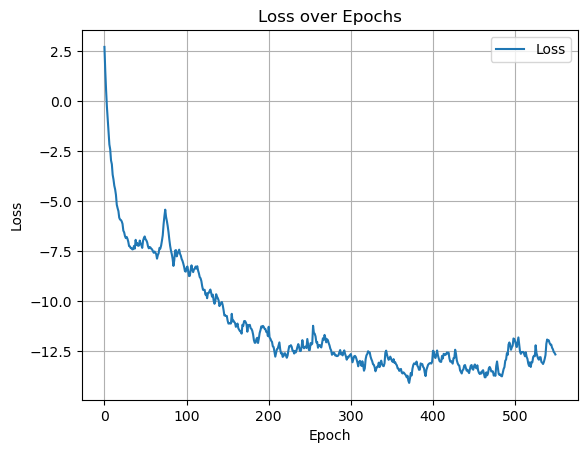

In [ ]:
import matplotlib.pyplot as plt

# Plot the losses over epochs
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()  

In [ ]:
accuracy_list = []
for candidate in model.optimizer.population:
    model.w = candidate  # Set the model's weight to the candidate.
    acc = (model.predict(X_test_exp).squeeze() == y_test.to(device)).float().mean().item()
    accuracy_list.append((candidate, acc))

final_pop = [candidate for candidate, _ in sorted(accuracy_list, key=lambda pair: pair[1], reverse=True)]

In [ ]:
def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

average_pairwise_distance(optimizer.population)

tensor(153.5215, device='mps:0')

In [ ]:
def population_majority_vote_accuracy(model, X, y):
    """
    For each sample, collect predictions from all individuals in the population,
    take the majority vote, and compare to ground truth labels.
    """
    n = X.size(0)
    votes = torch.zeros((len(model.population), n))

    for i, w in enumerate(model.population):
        logits = X @ w
        preds = (logits > 0).float()
        votes[i] = preds

    # Sum over voters and apply majority rule (>50%)
    majority_preds = (votes.mean(dim=0) > 0.5).float()
    accuracy = (majority_preds == y).float().mean().item() * 100
    return accuracy

def average_pairwise_distance(population):
    n = len(population)
    total_dist = 0
    count = 0

    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(population[i] - population[j])
            total_dist += dist
            count += 1

    return total_dist / count if count > 0 else 0

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

def visualize_predictions_on_random_samples(X_val_exp, y_val, original_images, individual_A, individual_B, model, n=10):
    """
    Visualize n random samples from the validation/test set using predictions
    from two candidate individuals.
    
    Args:
      X_val_exp (Tensor): Expanded validation features (shape: [N, 7850]).
      y_val (Tensor): True labels (shape: [N]).
      original_images (Tensor): Original validation images with bias removed 
                                (shape: [N, 785]), where first 784 values are the image.
      individual_A (Tensor): Candidate weight vector A (shape: [7850]).
      individual_B (Tensor): Candidate weight vector B (shape: [7850]).
      model: Instance of MultiClassLogisticRegressionWrapper.
      n (int): Number of random samples to display.
    """
    # Use X_val_exp's size (not X_val) to sample indices.
    indices = random.sample(range(X_val_exp.size(0)), n)

    # Create a grid of subplots.
    fig, axs = plt.subplots(n, 3, figsize=(8, n * 2))
    fig.suptitle("Predictions: True Label vs. Individuals' Predictions", fontsize=16)

    for i, idx in enumerate(indices):
        # Get the expanded input for candidate prediction (shape: (1, 7850)).
        x = X_val_exp[idx].unsqueeze(0)
        
        # For visualization: use the original image (remove bias column) and reshape to 28x28.
        img = original_images[idx].view(28, 28)
        true_label = int(y_val[idx].item())

        # Predict with Individual A using the candidate weight vector.
        scores_A = model.score_with(x, individual_A)  # shape: (1, 10)
        pred_A = torch.argmax(scores_A, dim=1).item()

        # Predict with Individual B using the candidate weight vector.
        scores_B = model.score_with(x, individual_B)
        pred_B = torch.argmax(scores_B, dim=1).item()

        # Plot the original image with true label.
        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"True: {true_label}")

        # Display Individual A's prediction.
        axs[i, 1].text(0.5, 0.5, f"{pred_A}", fontsize=16, ha='center', va='center')
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Individual A")

        # Display Individual B's prediction.
        axs[i, 2].text(0.5, 0.5, f"{pred_B}", fontsize=16, ha='center', va='center')
        axs[i, 2].axis('off')
        axs[i, 2].set_title("Individual B")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- Example usage ---
# Assume you have defined `find_most_diverse_pair` function:
def find_most_diverse_pair(population):
    max_dist = 0
    pair = (None, None)
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            dist = torch.norm(population[i] - population[j])
            if dist > max_dist:
                max_dist = dist
                pair = (population[i], population[j])
    return pair

# Get the two most diverse individuals from your optimizer's population.
indiv_A, indiv_B = find_most_diverse_pair(optimizer.population)

# For visualization, remove the bias column from X_test.
original_val_images = X_test[:, :-1]  # shape: (N_test, 784)

# Now call the visualization function with your test set.
visualize_predictions_on_random_samples(X_test_exp, y_test, original_val_images, indiv_A, indiv_B, model, n=10)

NameError: name 'optimizer' is not defined